In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.dpi"] = 120
plt.style.use("seaborn")


![image text](https://machinelearningmastery.com/wp-content/uploads/2019/11/How-to-Choose-Feature-Selection-Methods-For-Machine-Learning.png "image Title")

According to this article there are different methods to select features for categorical and numerical features. So my first and the most intuitive way to work would be:
separate features on categorical and numerical and process different selection tests.

In [2]:
# Plot helper function
def plot_feature_importance(importance, features, title=None):
    plt.bar(np.arange(len(features)), importance)
    plt.xticks(np.arange(len(features)), features)
    plt.tick_params("x", rotation=50)

    if title is not None:
        plt.title(title)

    plt.show()

## Demo data: Heart Disease

Feature Description from kaggle:
1. age
2. sex
3. chest pain type (4 values)
4. resting blood pressure
5. serum cholestoral in mg/dl
6. fasting blood sugar > 120 mg/dl
7. resting electrocardiographic results (values 0,1,2)
8. maximum heart rate achieved
9. exercise induced angina
10. oldpeak = ST depression induced by exercise relative to rest
11. the slope of the peak exercise ST segment
12. number of major vessels (0-3) colored by flourosopy
13. thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

Target:
Whether the patient had a heart disease or not

In [3]:
df_heart = pd.read_csv("data/heart.csv")

In [4]:
df_heart.astype("object").describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303,303,303,303,303,303,303,303,303,303.0,303,303,303,303
unique,41,2,4,49,152,2,3,91,2,40.0,3,5,4,2
top,58,1,0,120,197,0,1,162,0,0.0,2,0,2,1
freq,19,207,143,37,6,258,152,11,204,99.0,142,175,166,165


## Separate features on categorical and numerical

In [5]:
CATEGORICAL_FEATURES = ["sex", "cp", "fbs", "restecg", "exang", "slope", "ca", "thal"]
NUMERICAL_FEATURES = ["age", "trestbps", "chol", "thalach", "oldpeak"]

In [6]:
from sklearn import feature_selection

In [7]:
X_cat = df_heart[CATEGORICAL_FEATURES]
X_num = df_heart[NUMERICAL_FEATURES]
y = df_heart["target"]

### Categorical Feature Importance

Chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

In [8]:
chi_stats, p_values = feature_selection.chi2(X_cat, y)

In [9]:
np.where(p_values >= 0.05)[0]

array([2, 3])

fbs and restecg showed high p-value and low statistic, I wouldn't rely much on these features

### Chi-square

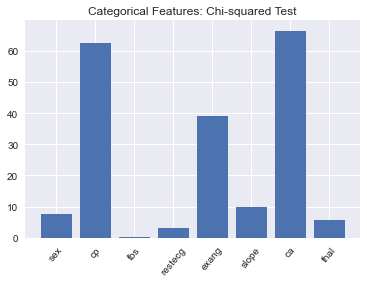

In [10]:
plot_feature_importance(chi_stats, CATEGORICAL_FEATURES, title="Categorical Features: Chi-squared Test")

In [11]:
mi = feature_selection.mutual_info_classif(X_cat, y)

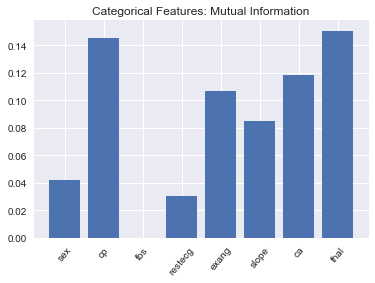

In [12]:
plot_feature_importance(mi, CATEGORICAL_FEATURES, title="Categorical Features: Mutual Information")

The results differ, however both techniques consistent that fbs has no effect at the target. Both techniques showed that sex and restecg are last important features.

### Numerical Feature Importance

#### ANOVA F-test

In [171]:
f_stats, p_values = feature_selection.f_classif(X_num, y)

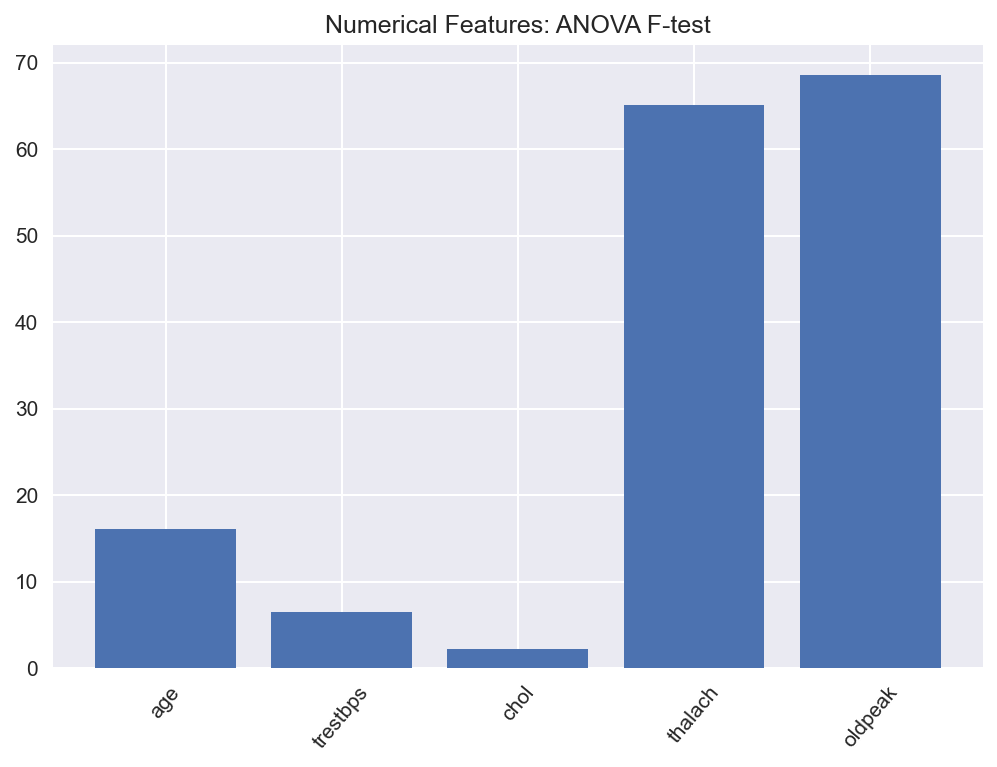

In [172]:
plot_feature_importance(f_stats, NUMERICAL_FEATURES, title="Numerical Features: ANOVA F-test")

In [63]:
def get_feature_types(df, categorical_unique_percentile=0.1):
    column_names = df.columns.values
    column_is_category_map = {}
    number_of_data_points = df.shape[0]

    for column_name in column_names:
        is_category = (
                len(df[column_name].unique()) / number_of_data_points
                <= categorical_unique_percentile
        )
        column_is_category_map[column_name] = "categorical" if is_category else "numerical"

    return column_is_category_map


In [73]:
df_heart = df_heart.rename(columns={"target": "label"})

In [74]:
feature_types = get_feature_types(df_heart)

In [125]:
CATEGORICAL_FEATURES = [k for k, v in feature_types.items() if( v == "categorical" and k != "label")]
NUMERICAL_FEATURES = [k for k,v in feature_types.items() if v == "numerical"]

In [126]:
CATEGORICAL_FEATURES

['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

In [155]:
from sklearn.ensemble import RandomForestClassifier


ALL_FEATURES = [*CATEGORICAL_FEATURES, *NUMERICAL_FEATURES]
X = df_heart[ALL_FEATURES]
model = RandomForestClassifier().fit(X, y)

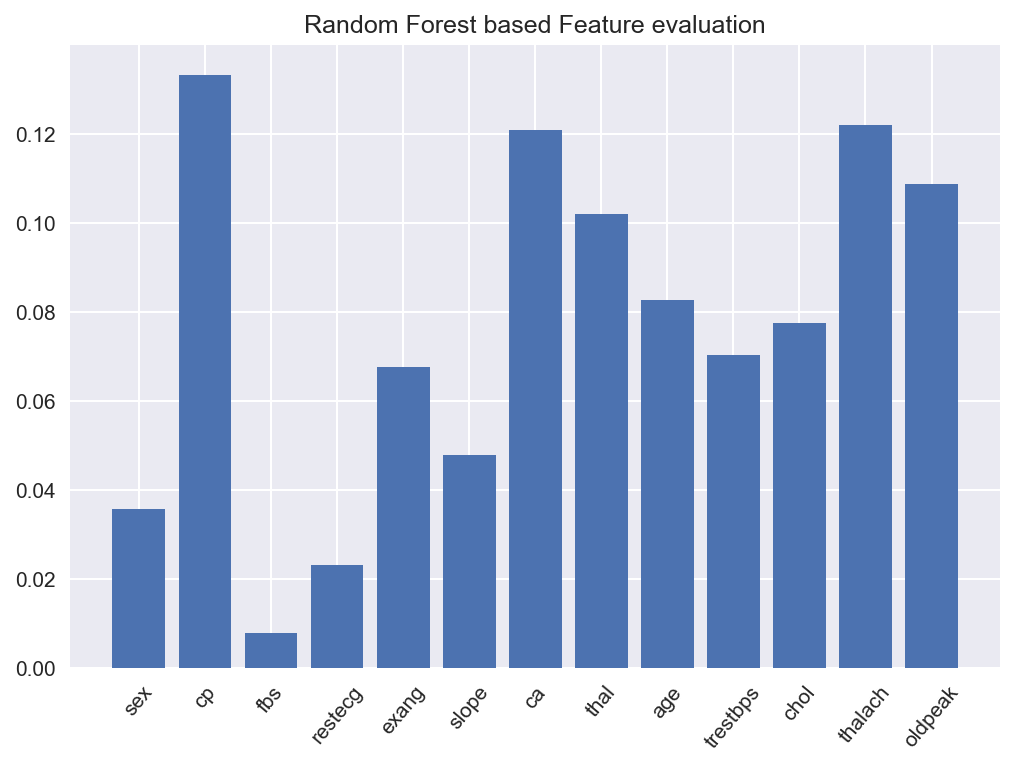

In [156]:
plot_feature_importance(model.feature_importances_, ALL_FEATURES, title="Random Forest based Feature evaluation")

TODO:
1. Create 2 tables (for numberic and categorical): rows: names, columns: scores
2. Figure out the threshold: try to get rid of some features and test it by using a model
3. Normalize (standradize or minmax scale numbers so that we can compare results across different tests)
4. Try Logistic Regression with L1 and explore coefficient

In [173]:
chi_stats

array([ 7.57683451, 62.59809791,  0.20293368,  2.97827075, 38.91437697,
        9.8040952 , 66.44076512,  5.79185297])

In [176]:
df_fi_cat = pd.DataFrame({"chi": chi_stats, "mutual_unfo":mi}, index=CATEGORICAL_FEATURES)

In [178]:
df_fi_num = pd.DataFrame({"f1":f_stats,},index=NUMERICAL_FEATURES)

In [181]:
cat_good_features = df_fi_cat[df_fi_cat["chi"] > 15].index.values

In [182]:
num_good_features = df_fi_num[df_fi_num["f1"] > 10].index.values

In [188]:
X_good = df_heart[[*cat_good_features, *num_good_features]]
X_all = df_heart[df_heart.columns.values[:-1]]

In [213]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_validate


X_train_good, X_test_good, y_train_good, y_test_good = train_test_split(X_good, y)
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y)


print("Random Forests")
print(
    f"All Features RF score: {cross_validate(RandomForestClassifier(), X_all, y)['test_score'].mean()}",
    f"Good Features RF score: {cross_validate(RandomForestClassifier(), X_good, y)['test_score'].mean()}",
    sep="\n"
)
print("=== == == == == == ===")
print("Ada Boost")
print(
    f"All Features RF score: {cross_validate(AdaBoostClassifier(), X_all, y)['test_score'].mean()}",
    f"Good Features RF score: {cross_validate(AdaBoostClassifier(), X_good, y)['test_score'].mean()}",
    sep="\n"
)
print("=== == == == == == ===")
print("Logistic Regression")
print(
    f"All Features LR score: {cross_validate(LogisticRegression(solver='liblinear'), X_all, y)['test_score'].mean()}",
    f"Good Features LR score: {cross_validate(LogisticRegression(solver='liblinear'), X_good, y)['test_score'].mean()}",
    sep="\n"
)
print("=== == == == == == ===")
print("SVC")
print(
    f"All Features LR score: {cross_validate(SVC(), X_all, y)['test_score'].mean()}",
    f"Good Features LR score: {cross_validate(SVC(), X_good, y)['test_score'].mean()}",
    sep="\n"
)


Random Forests
All Features RF score: 0.8083060109289617
Good Features RF score: 0.7754098360655737
=== == == == == == ===
Ada Boost
All Features RF score: 0.7851366120218579
Good Features RF score: 0.7656284153005466
=== == == == == == ===
Logistic Regression
All Features LR score: 0.8215300546448088
Good Features LR score: 0.834808743169399
=== == == == == == ===
SVC
All Features LR score: 0.6434972677595628
Good Features LR score: 0.6963387978142077


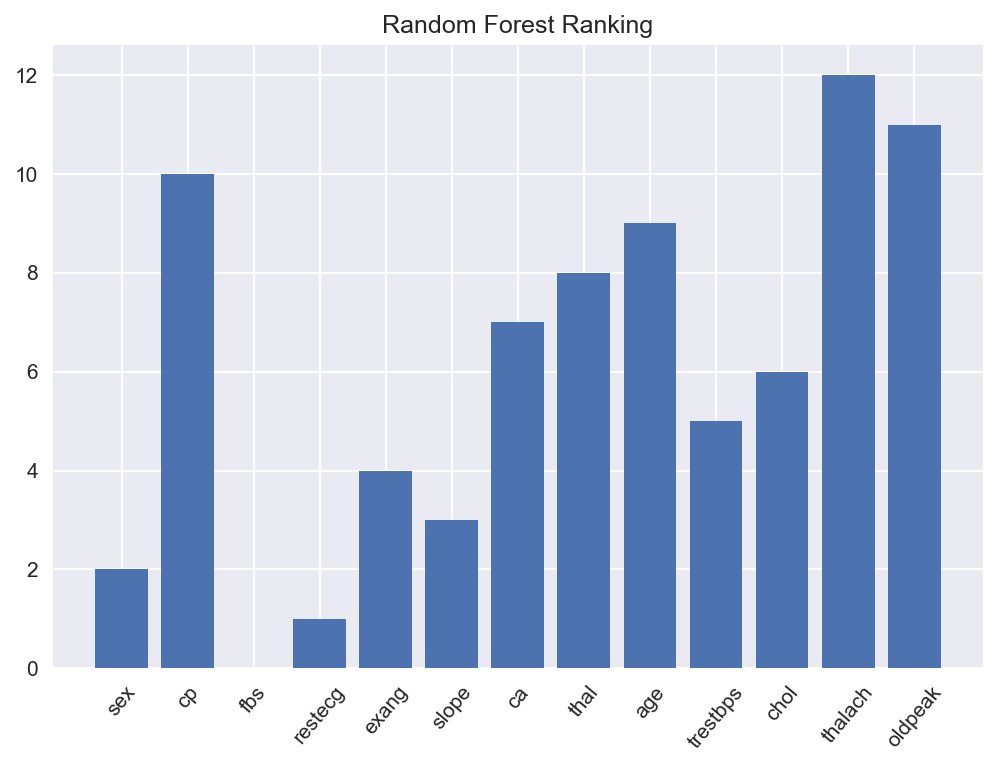

In [157]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier


selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=1)
selector.fit(X, y)
plot_feature_importance(selector.ranking_.max() - selector.ranking_, ALL_FEATURES, "Random Forest Ranking")

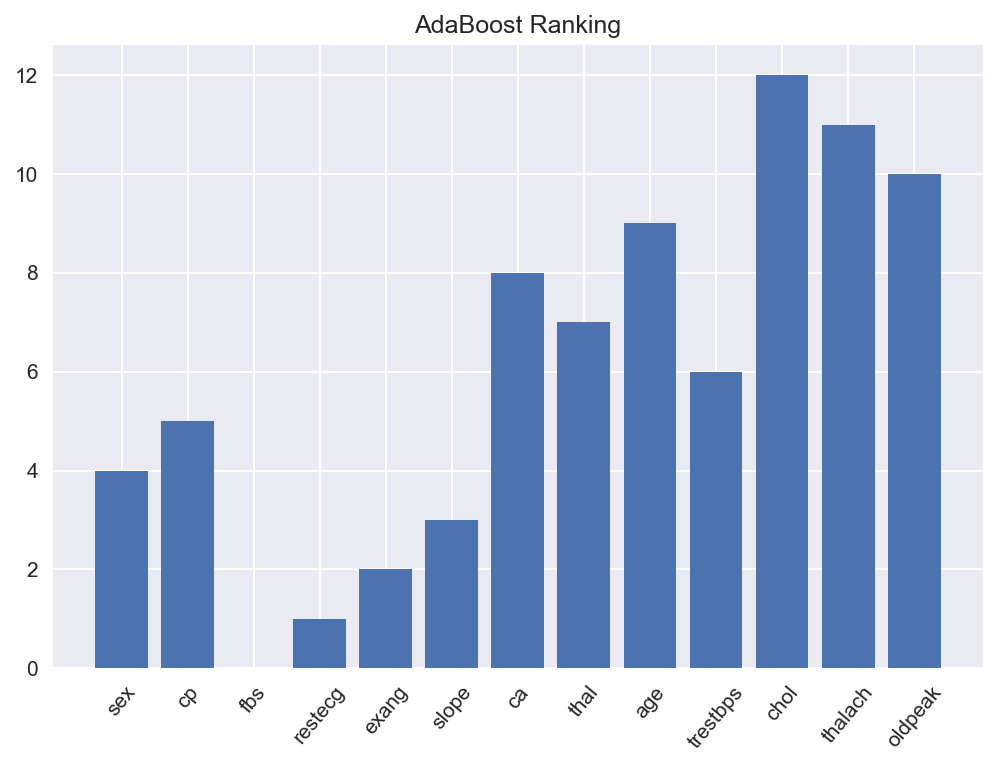

In [158]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostClassifier


selector = RFE(estimator=AdaBoostClassifier(), n_features_to_select=1)
selector.fit(X, y)
plot_feature_importance(selector.ranking_.max() - selector.ranking_, ALL_FEATURES, "AdaBoost Ranking")

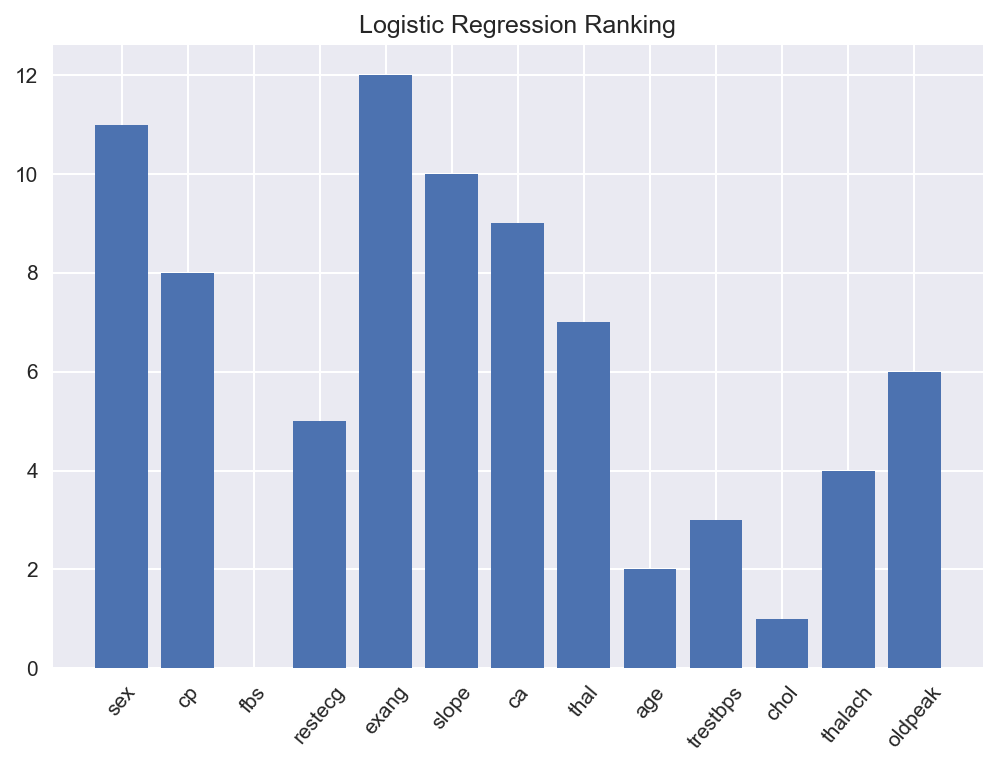

In [159]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


selector = RFE(estimator=LogisticRegression(penalty="l1", solver="liblinear"), n_features_to_select=1)
selector.fit(X, y)
plot_feature_importance(selector.ranking_.max() - selector.ranking_, ALL_FEATURES, "Logistic Regression Ranking")

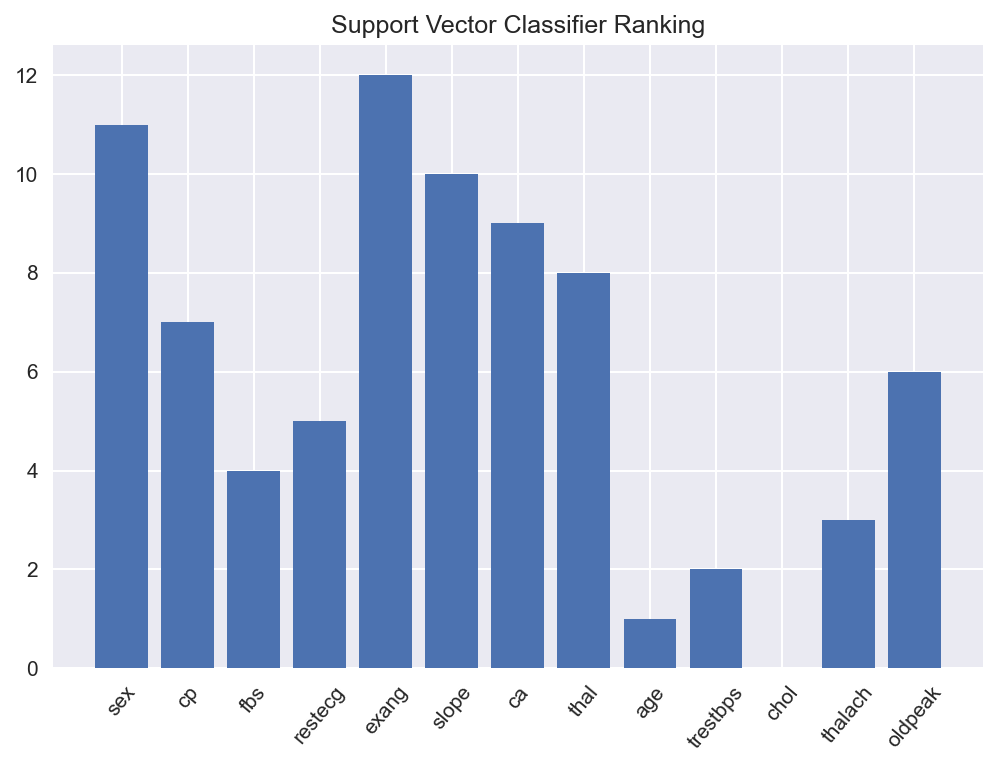

In [160]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC



selector = RFE(estimator=SVC(kernel="linear", C=1), n_features_to_select=1)
selector.fit(X, y)
plot_feature_importance(selector.ranking_.max() - selector.ranking_, ALL_FEATURES, title="Support Vector Classifier Ranking")